In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
from os.path import join as oj
from copy import deepcopy
import pandas as pd
import numpy.random as npr
import time
sys.path.append('../../src')
sys.path.append('../../interp')
import utils, lcp, train
from scipy.stats import ttest_ind


# sklearn models
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import export_graphviz, DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import auc


cred = (234/255, 51/255, 86/255)
cblue = (57/255, 138/255, 242/255)
out_dir = '../../results/interp_sim'
os.makedirs(out_dir, exist_ok=True)

Using TensorFlow backend.


# generate data

In [2]:
def gen_data(n=10, d=100, norm_beta=1, beta=None, var_eps=0.1, 
             s=None, seed=1, shift_type='None', shift_val=0.1):
    '''Generate data
    n : int
        number of samples
    d : int
        dimension
    norm_beta: float
        norm of beta
    var_eps: float
        variance of epsilon
        snr = norm_beta^2 / var_eps
    '''
    npr.seed(seed=seed)
    
    # x
    x = npr.randn(n, d)
    if 'shift' in shift_type:
        x += shift_val
    elif 'scale' in shift_type:
        S2 = np.cumsum(np.ones(d))
        S2 /= np.sum(S2)
        S2 = np.diag(np.sqrt(S2 * d))
        x = x @ S2
    elif 'spike' in shift_type:
        v = np.ones(d)
        v /= npl.norm(v)
        S = np.eye(d) + (np.sqrt(shift_val) - 1) * np.outer(v, v)
        x = x @ S
    elif shift_type == 'lap':
        x = npr.laplace(size=(n, d))
    
    # beta
    if s == None:
        s = d
    if beta is None:
        beta = np.zeros(d)
        beta[:s] = npr.randn(s)
        beta[:s] /= npl.norm(beta[:s])
        if norm_beta == 'd':
            norm_beta = d
        beta[:s] *= norm_beta
    
    var_mult = 0 if var_eps == 0 else np.sqrt(var_eps)
    eps = var_mult * npr.randn(n)
    y = x @ beta + eps

    return x, y, beta

In [8]:
n = 100
d = 10
beta = np.zeros(d)
beta[0] = 1
X, y, _ = gen_data(n=n, d=d, beta=beta, var_eps=0.1, 
             s=None, seed=1, shift_type='None', shift_val=0.1)

[<matplotlib.lines.Line2D at 0x7f4bb4eaabe0>]

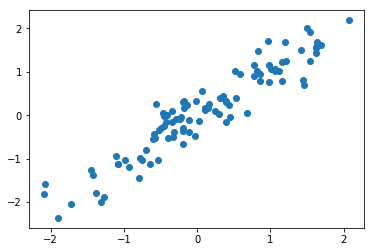

In [9]:
plt.plot(x[:, 0], y, 'o') 

# fit a model to it

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y) # defaults to 0.75: 0.25 split

In [11]:
m = train.regress(X, y, model_type='linear')

In [45]:
import shap, lime, lcp
def get_scores(m, X_train, x):
    '''Get scores using shap, lime, and lcp
    '''
    feature_names = [f'x{i}' for i in range(X_train.shape[1])]
    
    explainer_s = shap.KernelExplainer(m.predict, X_train, link="logit")
    shap_values = explainer_s.shap_values(x) #, nsamples=100)
    
    explainer_l = lime.lime_tabular.LimeTabularExplainer(X, feature_names=feature_names, 
                                                         mode='regression')
    lime_explanation = explainer_l.explain_instance(x, m.predict, 
                                                    num_features=x.size) #, top_labels=1)
    lime_values = [l[1] for l in lime_explanation.as_list()]
    
    explainer = lcp.Explainer(X_train, mode='regression')
    vals = explainer.explain_instance(x, m.predict, return_table=False)['contribution']
    

In [47]:
get_scores(m, X_train, X_test[0])

/accounts/projects/vision/.local/lib/python3.7/site-packages/shap/common.py:202: RuntimeWarning: invalid value encountered in log
  return np.log(x/(1-x))
/accounts/projects/vision/.local/lib/python3.7/site-packages/shap/explainers/kernel.py:545: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
